https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as ts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [2]:
dataset = pd.read_csv("pollution.csv")
display(dataset)
print(dataset.info())

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB
None


In [3]:
print(dataset.index)

RangeIndex(start=0, stop=43824, step=1)


In [4]:
# new column named "date"
# parse date information
dataset["date"] = pd.to_datetime(dataset[["year","month","day","hour"]],format ="%Y%m%d%H" )
dataset.drop(["year", "month","day","hour"], axis=1,inplace=True)
dataset["date"]

0       2010-01-01 00:00:00
1       2010-01-01 01:00:00
2       2010-01-01 02:00:00
3       2010-01-01 03:00:00
4       2010-01-01 04:00:00
                ...        
43819   2014-12-31 19:00:00
43820   2014-12-31 20:00:00
43821   2014-12-31 21:00:00
43822   2014-12-31 22:00:00
43823   2014-12-31 23:00:00
Name: date, Length: 43824, dtype: datetime64[ns]

In [5]:
# set new index as "date" and drop "No"
dataset.drop("No",axis=1, inplace=True)
display(dataset)
dataset.set_index("date",inplace=True)
display(dataset)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0,2014-12-31 19:00:00
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0,2014-12-31 20:00:00
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0,2014-12-31 21:00:00
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0,2014-12-31 22:00:00


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [6]:
dataset.columns=['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
display(dataset.head())

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
# fill na values with interpolation and drop first 24 columns
# first 24 values are NA
dataset["pollution"].interpolate(method="linear")
dataset = dataset[24:]
display(dataset)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


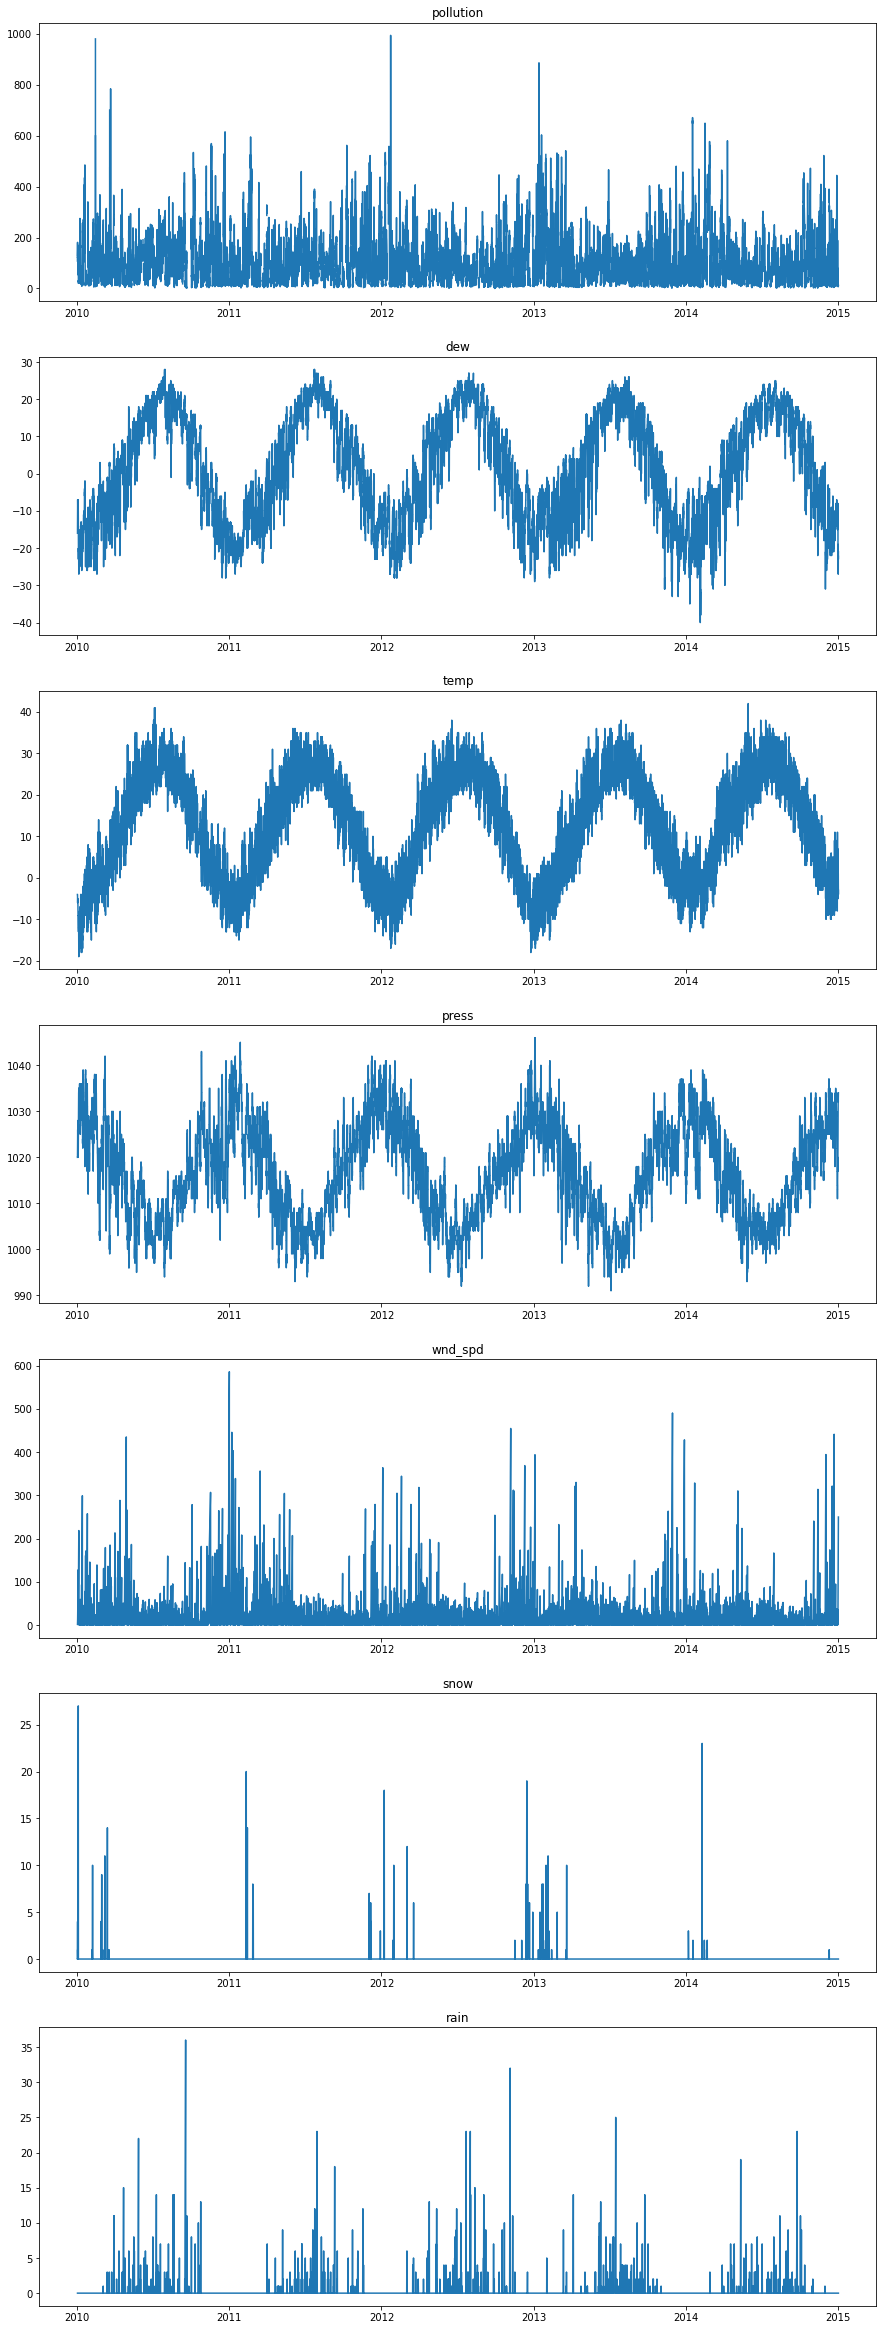

In [8]:
# plot each column separately
groups = [0, 1, 2, 3, 5, 6, 7]
j = 1
plt.figure(figsize=(15,6*7))
for i in groups:
    plt.subplot(7,1,j)
    plt.title(dataset.columns[i])
    plt.plot(dataset.iloc[:,i])
    j += 1

In [9]:
# label encoding on wind direction column
le = LabelEncoder()
dataset["wnd_dir"] = le.fit_transform(dataset["wnd_dir"])
display(dataset["wnd_dir"])

date
2010-01-02 00:00:00    2
2010-01-02 01:00:00    2
2010-01-02 02:00:00    2
2010-01-02 03:00:00    2
2010-01-02 04:00:00    2
                      ..
2014-12-31 19:00:00    1
2014-12-31 20:00:00    1
2014-12-31 21:00:00    1
2014-12-31 22:00:00    1
2014-12-31 23:00:00    1
Name: wnd_dir, Length: 43800, dtype: int32

In [10]:
# scale the input data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(dataset)
display(data_scaled)
print(type(data_scaled))

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.41399641, 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.42086644, 0.        ,
        0.        ],
       [0.01207243, 0.27941176, 0.26229508, ..., 0.4262155 , 0.        ,
        0.        ]])

<class 'numpy.ndarray'>


In [11]:
# def scaled_transform(X,min_data, max_data, min_range, max_range):
#     X_std = (X-min_data)/(max_data-min_data)
#     X_sc = X_std * (max_range - min_range) + (min_range)
#     return np.array(X_sc)

In [12]:
# min_range = -1
# max_range = 1
# min_data = dataset.values.min()
# max_data = dataset.values.max()
# print(min_data,max_data)
# data_scaled = scaled_transform(dataset,min_data, max_data, min_range, max_range)

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
#         print("shift")
#         print(df.iloc[:,0].shift(-i))
        cols.append(df.loc[:,0].shift(-i))
#         print(cols)
        if i == 0:
            names += [('var1(t)')]
        else:
            names += [('var1(t+%d)' % (i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
lags=2 #input t-1, t-2
n_hours = 3 #output t, t+1, t+2
n_features=8
reframed = series_to_supervised(data_scaled,lags,n_hours)
print("\nReframed")
display(reframed.head())


Reframed


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var1(t+1),var1(t+2)
2,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.182093,0.138833
3,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.138833,0.109658
4,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.109658,0.105634
5,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.105634,0.124748
6,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0,0.105634,0.124748,0.120724


In [15]:
# split train and test
test_hours =365*24
# print(reframed)
train = reframed.values[:-test_hours,:]
test = reframed.values[-test_hours:,:]
print("Train")
print(train.shape)
print("Test")
print(test.shape)


Train
(32209, 19)
Test
(8760, 19)


In [16]:
# split input and output
X_train, y_train = train[:,:-n_hours], train[:,-n_hours:]
X_test, y_test = test[:,:-n_hours], test[:,-n_hours:]
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
print(y_test)
# reshape [samples, timestep, features]
X_train=X_train.reshape(X_train.shape[0],lags,n_features)
X_test=X_test.reshape(X_test.shape[0],lags,n_features)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
print(X_train)

(32209, 16) (32209, 3) (8760, 16) (8760, 3)
[[0.04124748 0.04225352 0.04225352]
 [0.04225352 0.04225352 0.0362173 ]
 [0.04225352 0.0362173  0.03420523]
 ...
 [0.00804829 0.01006036 0.01006036]
 [0.01006036 0.01006036 0.00804829]
 [0.01006036 0.00804829 0.01207243]]
(32209, 2, 8) (32209, 3) (8760, 2, 8) (8760, 3)
[[[0.12977867 0.35294118 0.24590164 ... 0.00229001 0.         0.        ]
  [0.14889336 0.36764706 0.24590164 ... 0.00381099 0.         0.        ]]

 [[0.14889336 0.36764706 0.24590164 ... 0.00381099 0.         0.        ]
  [0.15995976 0.42647059 0.2295082  ... 0.00533197 0.         0.        ]]

 [[0.15995976 0.42647059 0.2295082  ... 0.00533197 0.         0.        ]
  [0.18209256 0.48529412 0.2295082  ... 0.00839101 0.03703704 0.        ]]

 ...

 [[0.02112676 0.30882353 0.16393443 ... 0.00458002 0.         0.        ]
  [0.01911469 0.32352941 0.18032787 ... 0.00992908 0.         0.        ]]

 [[0.01911469 0.32352941 0.18032787 ... 0.00992908 0.         0.        ]
  [0.0

In [17]:
# design the LSTM model
model = Sequential()
model.add(LSTM(50,input_shape=(lags,n_features)))
model.add(Dense(n_hours,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.00001),loss="mse")

# fit network
history = model.fit(X_train, y_train, epochs=350, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/350
448/448 - 10s - loss: 0.0121 - val_loss: 0.0120 - 10s/epoch - 22ms/step
Epoch 2/350
448/448 - 3s - loss: 0.0102 - val_loss: 0.0110 - 3s/epoch - 6ms/step
Epoch 3/350
448/448 - 3s - loss: 0.0096 - val_loss: 0.0106 - 3s/epoch - 6ms/step
Epoch 4/350
448/448 - 3s - loss: 0.0093 - val_loss: 0.0103 - 3s/epoch - 6ms/step
Epoch 5/350
448/448 - 3s - loss: 0.0090 - val_loss: 0.0101 - 3s/epoch - 6ms/step
Epoch 6/350
448/448 - 3s - loss: 0.0088 - val_loss: 0.0099 - 3s/epoch - 6ms/step
Epoch 7/350
448/448 - 3s - loss: 0.0086 - val_loss: 0.0096 - 3s/epoch - 6ms/step
Epoch 8/350
448/448 - 3s - loss: 0.0084 - val_loss: 0.0094 - 3s/epoch - 6ms/step
Epoch 9/350
448/448 - 3s - loss: 0.0083 - val_loss: 0.0092 - 3s/epoch - 6ms/step
Epoch 10/350
448/448 - 3s - loss: 0.0081 - val_loss: 0.0090 - 3s/epoch - 6ms/step
Epoch 11/350
448/448 - 3s - loss: 0.0079 - val_loss: 0.0089 - 3s/epoch - 6ms/step
Epoch 12/350
448/448 - 3s - loss: 0.0078 - val_loss: 0.0087 - 3s/epoch - 6ms/step
Epoch 13/350
448/448 -

Epoch 101/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0015 - 3s/epoch - 6ms/step
Epoch 102/350
448/448 - 2s - loss: 0.0016 - val_loss: 0.0014 - 2s/epoch - 6ms/step
Epoch 103/350
448/448 - 2s - loss: 0.0016 - val_loss: 0.0014 - 2s/epoch - 6ms/step
Epoch 104/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 105/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 106/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 107/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 108/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 109/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 110/350
448/448 - 2s - loss: 0.0016 - val_loss: 0.0014 - 2s/epoch - 6ms/step
Epoch 111/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoch 112/350
448/448 - 3s - loss: 0.0016 - val_loss: 0.0014 - 3s/epoch - 6ms/step
Epoc

Epoch 200/350
448/448 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 6ms/step
Epoch 201/350
448/448 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 5ms/step
Epoch 202/350
448/448 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 6ms/step
Epoch 203/350
448/448 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 6ms/step
Epoch 204/350
448/448 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 6ms/step
Epoch 205/350
448/448 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 5ms/step
Epoch 206/350
448/448 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 6ms/step
Epoch 207/350
448/448 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 6ms/step
Epoch 208/350
448/448 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 6ms/step
Epoch 209/350
448/448 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 6ms/step
Epoch 210/350
448/448 - 2s - loss: 0.0015 - val_loss: 0.0013 - 2s/epoch - 5ms/step
Epoch 211/350
448/448 - 3s - loss: 0.0015 - val_loss: 0.0013 - 3s/epoch - 6ms/step
Epoc

Epoch 299/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 300/350
448/448 - 2s - loss: 0.0014 - val_loss: 0.0012 - 2s/epoch - 5ms/step
Epoch 301/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 302/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 303/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 304/350
448/448 - 2s - loss: 0.0014 - val_loss: 0.0012 - 2s/epoch - 6ms/step
Epoch 305/350
448/448 - 2s - loss: 0.0014 - val_loss: 0.0012 - 2s/epoch - 6ms/step
Epoch 306/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 307/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 308/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoch 309/350
448/448 - 2s - loss: 0.0014 - val_loss: 0.0012 - 2s/epoch - 5ms/step
Epoch 310/350
448/448 - 3s - loss: 0.0014 - val_loss: 0.0012 - 3s/epoch - 6ms/step
Epoc

In [18]:
print(model.output.shape)

(None, 3)


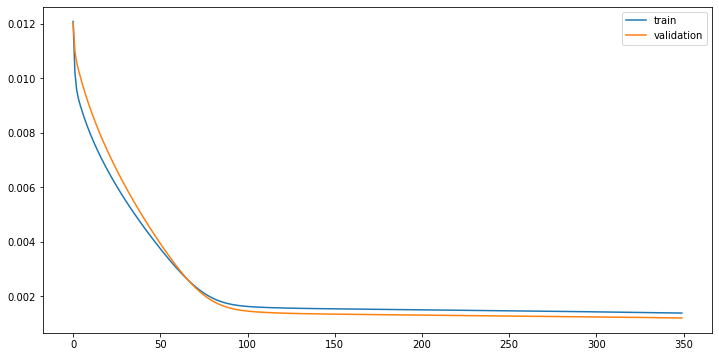

In [28]:
# plot history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [20]:
y_pred = model.predict(X_test)

274/274 [==============================] - 2s 3ms/step


In [21]:
X_test = X_test.reshape(X_test.shape[0],16)
print(y_pred.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred)
print(y_test)

(8760, 3)
(8760, 16)
(8760, 3)
[[0.03348462 0.03336923 0.03339541]
 [0.03585622 0.03270337 0.03244195]
 [0.03649676 0.03718121 0.03681036]
 ...
 [0.00930771 0.00863118 0.00948801]
 [0.00664301 0.00746439 0.00738705]
 [0.01006362 0.00838732 0.00905947]]
[[0.04124748 0.04225352 0.04225352]
 [0.04225352 0.04225352 0.0362173 ]
 [0.04225352 0.0362173  0.03420523]
 ...
 [0.00804829 0.01006036 0.01006036]
 [0.01006036 0.01006036 0.00804829]
 [0.01006036 0.00804829 0.01207243]]


In [22]:

inv_pred = np.concatenate((y_pred, X_test[:,-(n_features-n_hours):]), axis=1)
print(inv_pred.shape)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0:n_hours]

inv_test=np.concatenate((y_test,X_test[:,-(n_features-n_hours):]),axis=1)
inv_test = scaler.inverse_transform(inv_test)
inv_test = inv_test[:,0:n_hours]

rmse = mean_squared_error(y_pred, y_test) ** (0.5)
print('Test RMSE: %.3f' % rmse)

(8760, 8)
Test RMSE: 0.035


In [23]:
# def inverse_transform(X_scaled,min_data,max_data,min_range,max_range):
#     X_std = (X_scaled - (min_range))/(max_range-min_range)
#     X = X_std * (max_data - min_data) + min_data
#     return X

In [24]:
# inv_pred = np.concatenate((y_pred, X_test), axis=1)
# inv_pred = inverse_transform(inv_pred,min_data,max_data,min_range,max_range)
# inv_pred = inv_pred[:,0:n_hours]

# inv_test=np.concatenate((y_test,X_test),axis=1)
# inv_test = inverse_transform(inv_test,min_data,max_data,min_range,max_range)
# inv_test = inv_test[:,0:n_hours]

# rmse = mean_squared_error(inv_pred, inv_test) ** (0.5)
# print('Test RMSE: %.3f' % rmse)

In [25]:
print("Predicted y")
print(inv_pred)

print("Actual y")
print(inv_test)

Predicted y
[[ 33.28370769 -37.73089223 -16.96288002]
 [ 35.64107984 -37.77617085 -17.02104097]
 [ 36.27777791 -37.47167799 -16.75456799]
 ...
 [  9.25186419 -39.41307969 -18.4212314 ]
 [  6.603149   -39.49242146 -18.54938992]
 [ 10.00323856 -39.429662   -18.44737204]]
Actual y
[[ 41.         -37.12676056 -16.42253521]
 [ 42.         -37.12676056 -16.79074447]
 [ 42.         -37.53722334 -16.91348089]
 ...
 [  8.         -39.31589537 -18.38631791]
 [ 10.         -39.31589537 -18.50905433]
 [ 10.         -39.4527163  -18.26358149]]


Question? before inverse scaling y_red and y_test columns are proportional bu after inverse scaling operation one of the feature becomes negative.

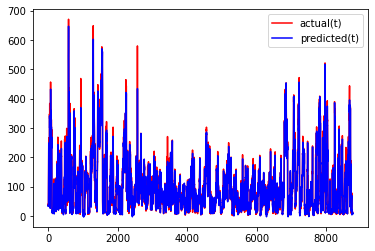

In [29]:
plt.plot(inv_test[:,0],'r',label="actual(t)")
plt.plot(inv_pred[:,0],'b',label="predicted(t)")

plt.legend()
plt.show()